Evaluation
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s4e10
!unzip /content/playground-series-s4e10.zip
!rm /content/playground-series-s4e10.zip

Mounted at /content/drive
 69% 1.00M/1.45M [00:00<00:00, 1.98MB/s]
100% 1.45M/1.45M [00:00<00:00, 2.59MB/s]
Archive:  /content/playground-series-s4e10.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install autogluon.tabular[all]
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.7 

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from autogluon.tabular import TabularDataset, TabularPredictor
from scipy.stats import boxcox
import seaborn as sns
from imblearn.over_sampling import SMOTE

## Load Data

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
from category_encoders import TargetEncoder

cat_cols = train.select_dtypes(include=['object']).columns

encoder = TargetEncoder(cols=cat_cols, smoothing=1)

train_encoded = encoder.fit_transform(train.drop('loan_status', axis = 1), train['loan_status'])
test_encoded = encoder.transform(test)
train_encoded['loan_status'] = train['loan_status']

In [ ]:
# SMOTE
smote = SMOTE(sampling_strategy=0.43, random_state=29)
# Perform SMOTE
train_smote, t = smote.fit_resample(train_encoded.drop('loan_status', axis=1), train_encoded['loan_status'])
# Add the target column back to the resampled dataset
train_smote['loan_status'] = t

In [ ]:
train = train_smote.copy(deep = True)
test = test_encoded.copy(deep = True)

In [ ]:
# List of features to apply Box-Cox transform
boxcox_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']

# Dictionary to store the lambda values for each feature
boxcox_lambdas = {}

# Apply Box-Cox to train and store lambdas
for feature in boxcox_features:
    # Ensure positive values by adding a small constant if necessary
    min_value = train[feature].min()
    if min_value <= 0:
        train[feature] = train[feature] - min_value + 1

    # Apply Box-Cox and store the lambda
    train[feature + '_boxcox'], fitted_lambda = boxcox(train[feature])
    boxcox_lambdas[feature] = fitted_lambda

# Apply the same Box-Cox transformation to test using the stored lambdas
for feature in boxcox_features:
    # Ensure positive values in test by adding the same constant shift as in train
    min_value = train[feature].min()  # Same shift from train
    if min_value <= 0:
        test[feature] = test[feature] - min_value + 1

    # Apply the Box-Cox transformation using the lambda from the train set
    test[feature + '_boxcox'] = boxcox(test[feature], lmbda=boxcox_lambdas[feature])

In [ ]:
epsilon = 1e-6  # This small constant will ensure that the log transformation works

# Apply log transformation with epsilon added to handle zeros
train['loan_percent_income_log'] = np.log(train['loan_percent_income'] + epsilon)
test['loan_percent_income_log'] = np.log(test['loan_percent_income'] + epsilon)

In [ ]:
train["loantoincome"] = (train["loan_amnt"] / train["person_income"]) - train["loan_percent_income"]
test["loantoincome"] = (test["loan_amnt"] / test["person_income"]) - test["loan_percent_income"]

In [ ]:
age_bins = [19, 25, 30, 35, 40, 60, 200]
train['person_age_bin'] = pd.cut(train['person_age'], bins=age_bins, labels=['20-25', '26-30', '30-35', '36-40', '45-60', '60+'])
test['person_age_bin'] = pd.cut(test['person_age'], bins=age_bins, labels=['20-25', '26-30', '30-35', '36-40', '45-60', '60+'])

## Adversarial CV
Adversarial CV ROC AUC scores: [0.49701454 0.495505   0.50004573 0.50130812 0.50519442] <br>
Mean ROC AUC score: 0.4998135608272342

In [ ]:
# tmp1 = train.drop('loan_status', axis = 1).copy(deep = True)
# tmp2 = test.copy(deep = True)
# tmp1['is_test'] = 0
# tmp2['is_test'] = 1
# combined = pd.concat([tmp1, tmp2])
# object_cols = combined.select_dtypes(include=['object']).columns
# combined_encoded = pd.get_dummies(combined, columns=object_cols, drop_first=True)

# # Split the combined data into features and target
# X = combined_encoded.drop(columns=['is_test'])
# y = combined_encoded['is_test']

# # Create a pipeline with a scaler and XGBoost model
# model = make_pipeline(StandardScaler(), xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))

# # Perform cross-validation (5-fold)
# cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# # Print the ROC AUC scores
# print("Adversarial CV ROC AUC scores:", cv_scores)
# print("Mean ROC AUC score:", cv_scores.mean())

## Eda
Add features df["loantoincome"] = (df["loan_amnt"] / df["person_income"]) - df["loan_percent_income"] <br>

Add outlier analysis

In [ ]:
train.loan_status.value_counts()

,count
loan_status,
0,50295
1,50295


In [ ]:
train.dtypes

,0
person_age,int64
person_income,int64
person_home_ownership,object
person_emp_length,float64
loan_intent,object
loan_grade,object
loan_amnt,int64
loan_int_rate,float64
loan_percent_income,float64
cb_person_default_on_file,object


In [ ]:
age_bins = [20, 25, 30, 35, 40, 60, 200]
train['person_age_bin'] = pd.cut(train['person_age'], bins=age_bins, labels=['20-25', '26-30', '30-35', '36-40', '45-60', '60+'])
test['person_age_bin'] = pd.cut(test['person_age'], bins=age_bins, labels=['20-25', '26-30', '30-35', '36-40', '45-60', '60+'])


In [ ]:
display(train['person_age_bin'].value_counts()/train.shape[0]*100)
test['person_age_bin'].value_counts()/test.shape[0]*100

,count
person_age_bin,
20-25,47.802882
26-30,30.069060
30-35,11.409327
36-40,6.527411
45-60,4.036150
60+,0.134709


,count
person_age_bin,
20-25,47.659727
26-30,30.341705
30-35,11.202619
36-40,6.647399
45-60,4.007878
60+,0.135557


<ipython-input-56-3c062d9ad531>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train.groupby('person_age_bin')['loan_status'].mean() * 100


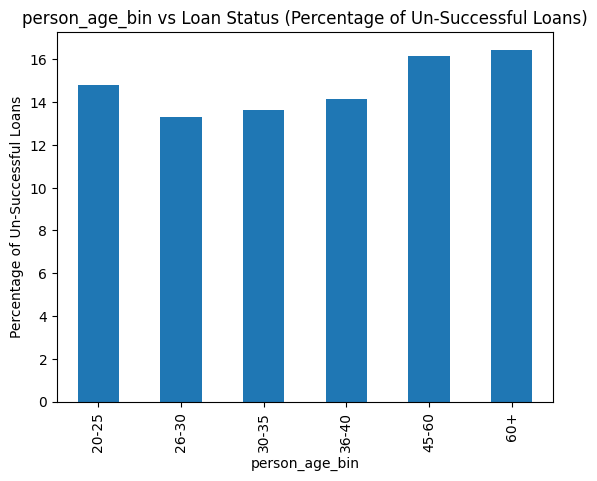

In [ ]:
# Percentage distribution of loan status within each 'loan_grade' category
grouped = train.groupby('person_age_bin')['loan_status'].mean() * 100
grouped.plot(kind='bar')
plt.title('person_age_bin vs Loan Status (Percentage of Un-Successful Loans)')
plt.xlabel('person_age_bin')
plt.ylabel('Percentage of Un-Successful Loans')
plt.show()

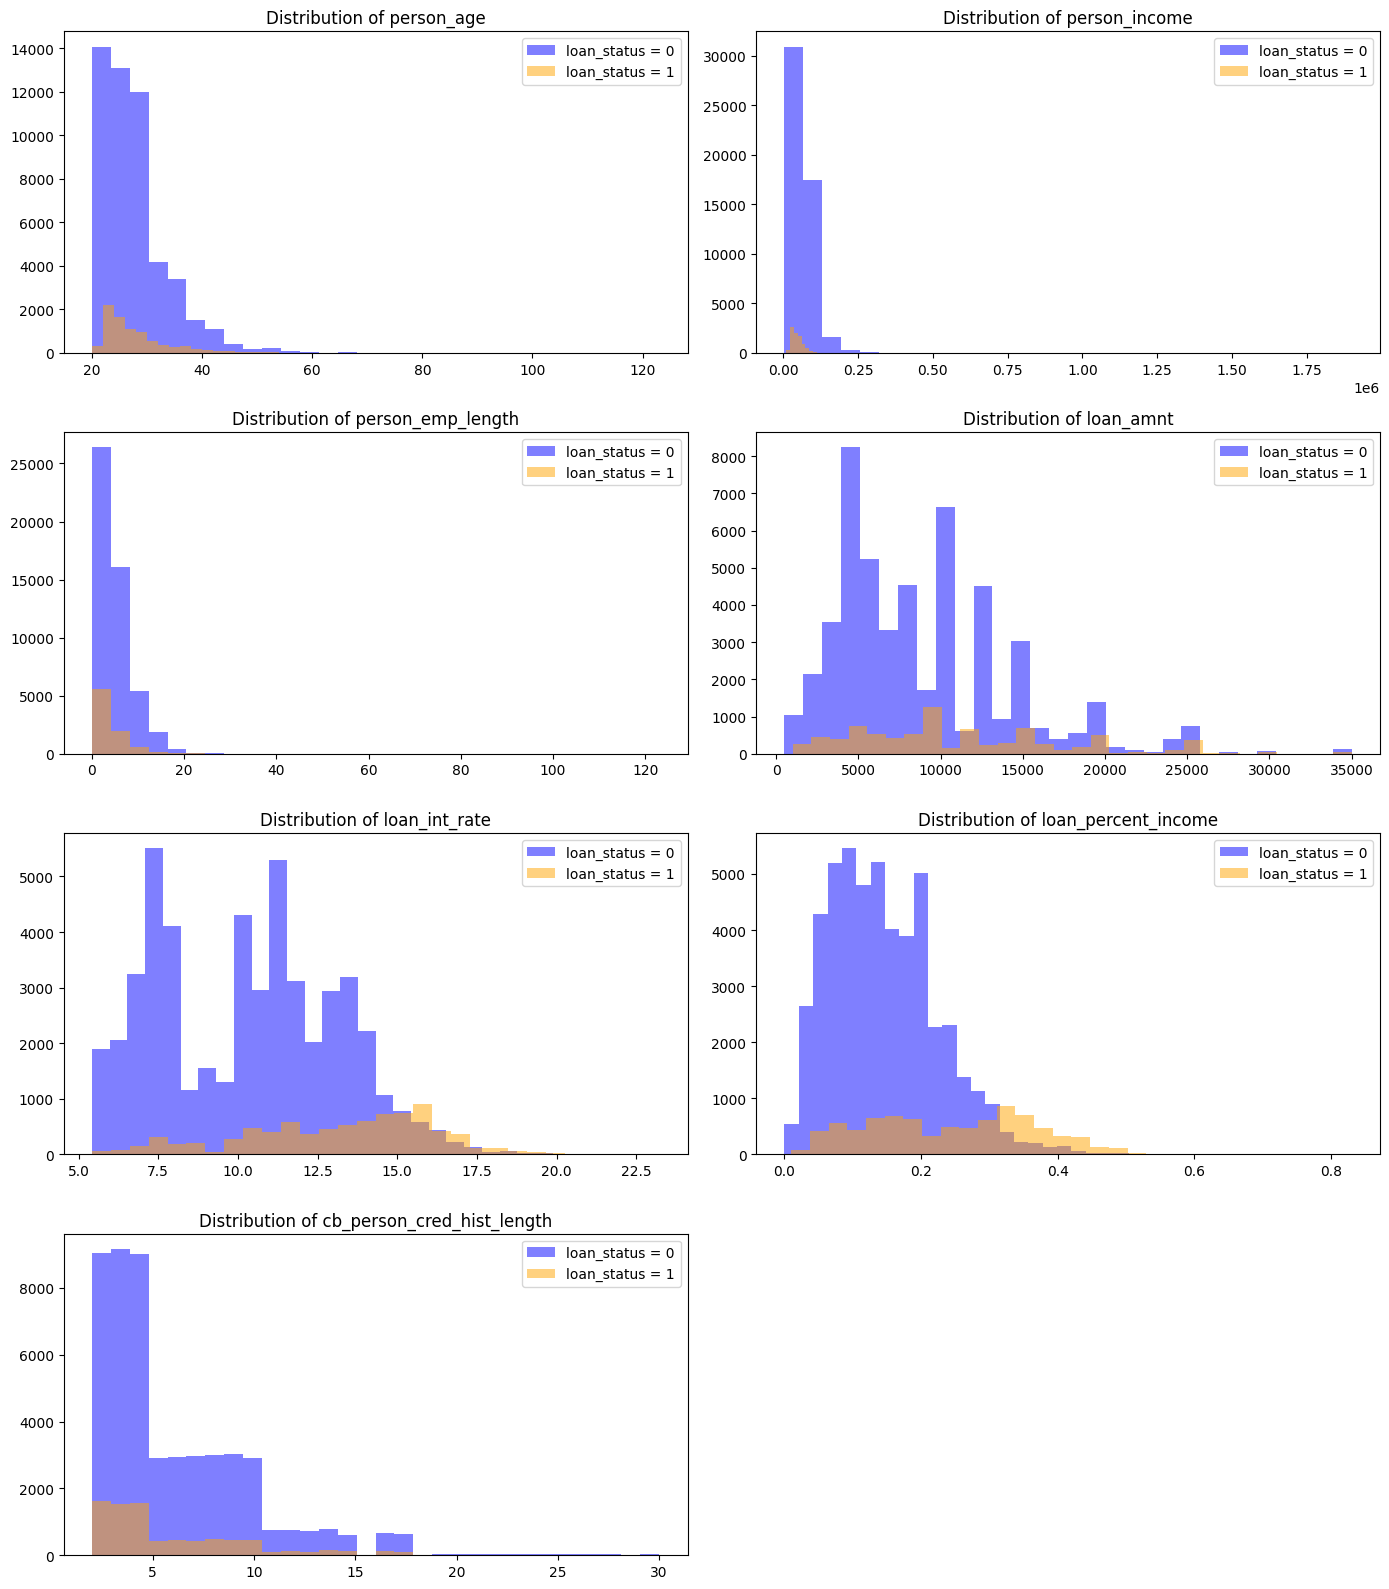

In [ ]:
# Define numerical columns to plot
numerical_columns = ['person_age', 'person_income', 'person_emp_length',
                     'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                     'cb_person_cred_hist_length']

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(numerical_columns):
    # Get data for each loan_status category
    loan_status_0 = train[train['loan_status'] == 0][col]
    loan_status_1 = train[train['loan_status'] == 1][col]

    # Plot histograms for each category with different colors
    axes[i].hist(loan_status_0, bins=30, alpha=0.5, label='loan_status = 0', color='blue')
    axes[i].hist(loan_status_1, bins=30, alpha=0.5, label='loan_status = 1', color='orange')

    axes[i].set_title(f"Distribution of {col}")
    axes[i].legend()

# Remove extra subplot
fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()

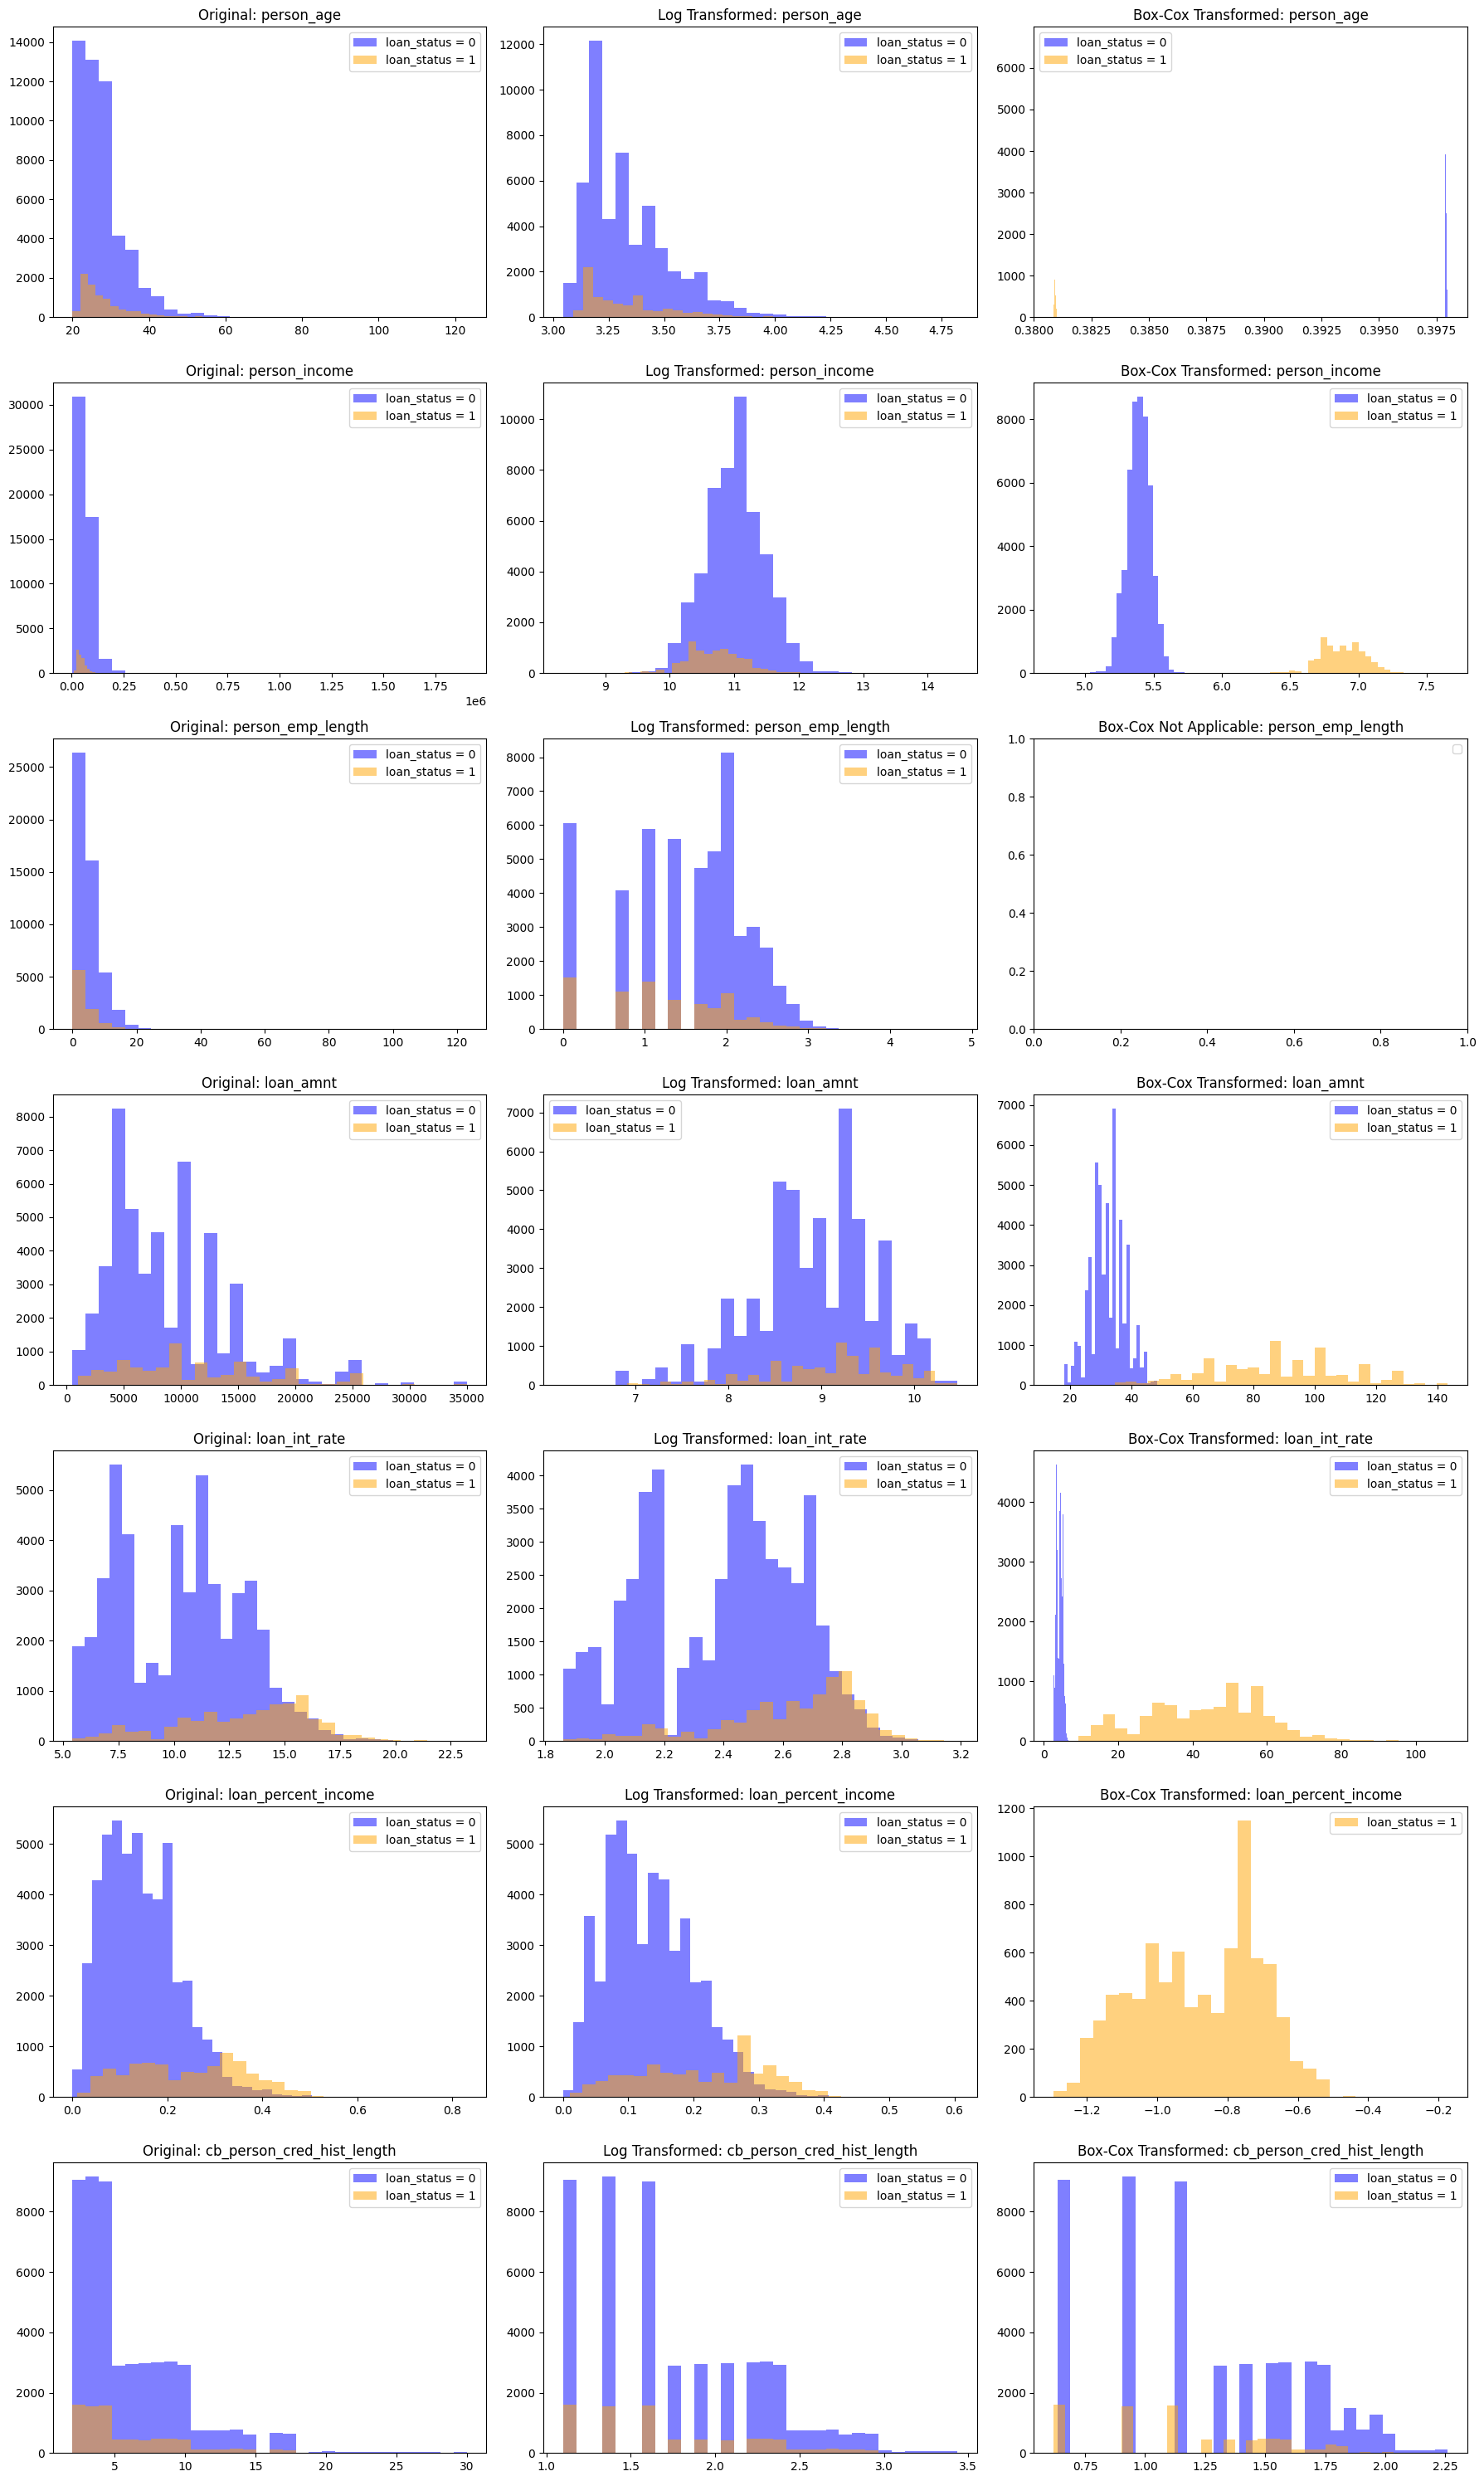

In [ ]:
# Set up the matplotlib figure: 3 columns (Original, Log, Box-Cox) for each feature
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=3, figsize=(18, 30))

# Loop through columns to apply log and Box-Cox transformation, separating by loan_status
for i, col in enumerate(numerical_columns):
    for loan_status in [0, 1]:
        # Separate data by loan_status
        original_data = train[train['loan_status'] == loan_status][col].dropna()  # Drop NaNs

        # Log transformation
        log_transformed = np.log1p(original_data)  # Log(1 + data)

        # Box-Cox transformation (only works with positive data)
        if (original_data > 0).all():
            boxcox_transformed, _ = boxcox(original_data)
        else:
            boxcox_transformed = np.nan  # If data contains non-positive values

        # Define colors for each loan_status
        color = 'blue' if loan_status == 0 else 'orange'
        label = f"loan_status = {loan_status}"

        # Plot original data
        axes[i, 0].hist(original_data, bins=30, alpha=0.5, label=label, color=color)
        axes[i, 0].set_title(f"Original: {col}")

        # Plot log-transformed data
        axes[i, 1].hist(log_transformed, bins=30, alpha=0.5, label=label, color=color)
        axes[i, 1].set_title(f"Log Transformed: {col}")

        # Plot Box-Cox transformed data
        if not np.isnan(boxcox_transformed).all():
            axes[i, 2].hist(boxcox_transformed, bins=30, alpha=0.5, label=label, color=color)
            axes[i, 2].set_title(f"Box-Cox Transformed: {col}")
        else:
            axes[i, 2].set_title(f"Box-Cox Not Applicable: {col}")

    # Add legends to each row
    for ax in axes[i]:
        ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

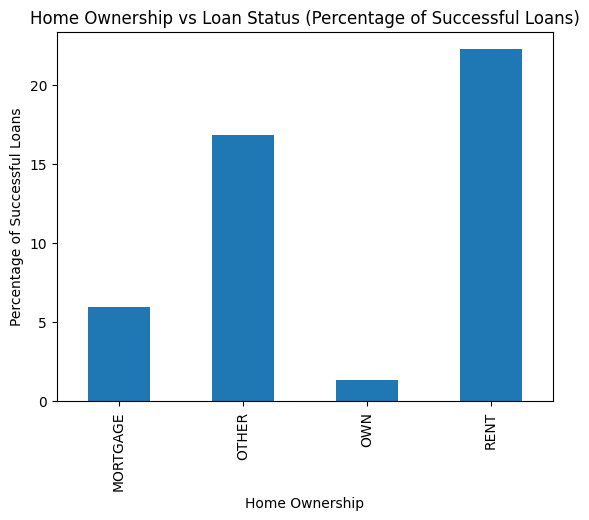

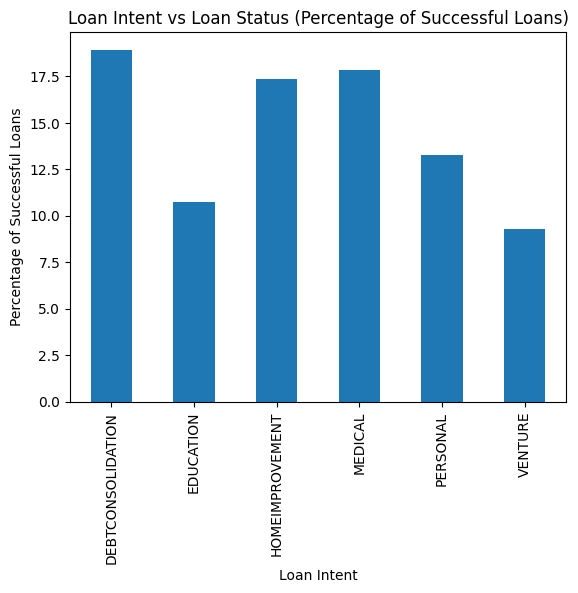

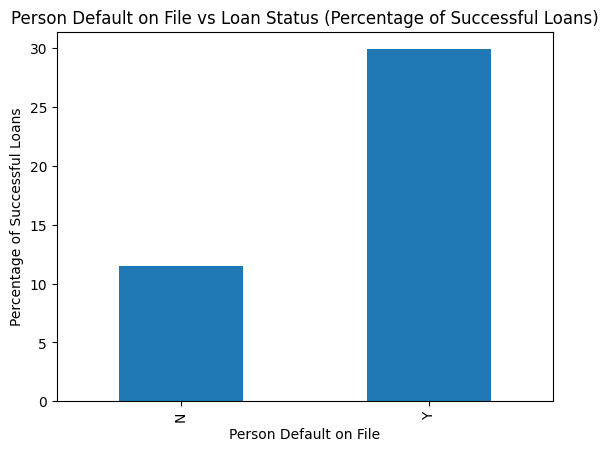

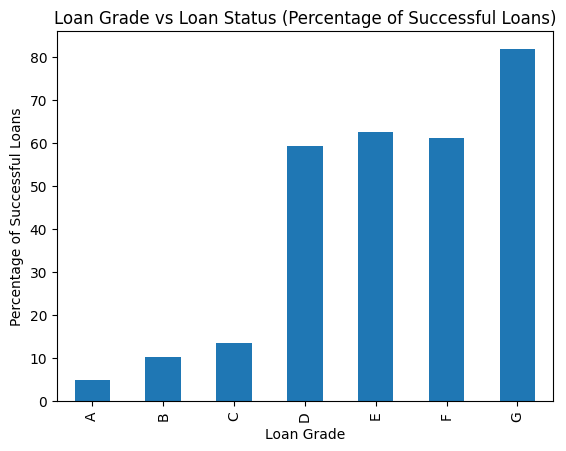

In [ ]:
# Percentage distribution of loan status within each 'person_home_ownership' category
grouped = train.groupby('person_home_ownership')['loan_status'].mean() * 100
grouped.plot(kind='bar')
plt.title('Home Ownership vs Loan Status (Percentage of Successful Loans)')
plt.xlabel('Home Ownership')
plt.ylabel('Percentage of Successful Loans')
plt.show()

# Percentage distribution of loan status within each 'loan_intent' category
grouped = train.groupby('loan_intent')['loan_status'].mean() * 100
grouped.plot(kind='bar')
plt.title('Loan Intent vs Loan Status (Percentage of Successful Loans)')
plt.xlabel('Loan Intent')
plt.ylabel('Percentage of Successful Loans')
plt.show()

# Percentage distribution of loan status within each 'cb_person_default_on_file' category
grouped = train.groupby('cb_person_default_on_file')['loan_status'].mean() * 100
grouped.plot(kind='bar')
plt.title('Person Default on File vs Loan Status (Percentage of Successful Loans)')
plt.xlabel('Person Default on File')
plt.ylabel('Percentage of Successful Loans')
plt.show()

# Percentage distribution of loan status within each 'loan_grade' category
grouped = train.groupby('loan_grade')['loan_status'].mean() * 100
grouped.plot(kind='bar')
plt.title('Loan Grade vs Loan Status (Percentage of Successful Loans)')
plt.xlabel('Loan Grade')
plt.ylabel('Percentage of Successful Loans')
plt.show()

## Outlier Remove Rows

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns

lof = LocalOutlierFactor(n_neighbors=20)
outliers = lof.fit_predict(train[numeric_cols])
train_cleaned = train[outliers == 1]  # 1 means inlier, -1 means outlier

In [ ]:
train.shape, train_cleaned.shape

((71921, 19), (57189, 19))

## Correlation Remove Features

In [ ]:
numeric_cols = train_poly_df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'loan_status']

# Calculate correlation between numeric features
corr = train_poly_df[numeric_cols].corr()

# Set a threshold for correlation (e.g., 0.7)
threshold = 0.7

# Get the upper triangle of the correlation matrix
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature with correlation greater than threshold
to_drop = [index for index in upper_tri.columns if any(abs(upper_tri[index]) > threshold)]

In [ ]:
to_drop = ['cb_person_cred_hist_length',
 'person_age',
 'person_income',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income']

In [ ]:
train_poly_df = train_poly_df.drop(to_drop, axis = 1)

## Polynomial Feature expansion

In [ ]:
cat_cols = train.select_dtypes(include=['object']).columns

In [ ]:
# # Separate features and target variable in both train and test datasets
# X_train = train[numeric_cols]
# y_train = train['loan_status']

# X_test = test[numeric_cols]

# # Initialize PolynomialFeatures transformer (degree 2 for quadratic expansion, can be adjusted)
# poly = PolynomialFeatures(degree=2, include_bias=False)

# # Fit and transform the training data
# X_train_poly = poly.fit_transform(X_train)

# # Transform the test data using the same polynomial expansion
# X_test_poly = poly.transform(X_test)

# # Convert back to a DataFrame for easier inspection (optional)
# poly_features = poly.get_feature_names_out(numeric_cols)
# train_poly_df = pd.DataFrame(X_train_poly, columns=poly_features)
# test_poly_df = pd.DataFrame(X_test_poly, columns=poly_features)

# # Optionally, add the target column back to the DataFrame
# train_poly_df['loan_status'] = y_train.values


In [ ]:
# train_poly_df[cat_cols] = train[cat_cols]
# test_poly_df.index = test.index
# test_poly_df[cat_cols] = test[cat_cols]

## Target encoding

In [ ]:
# from category_encoders import TargetEncoder

# cat_cols = train.select_dtypes(include=['object']).columns

# encoder = TargetEncoder(cols=cat_cols, smoothing=1)

# train_encoded = encoder.fit_transform(train.drop('loan_status', axis = 1), train['loan_status'])
# test_encoded = encoder.transform(test)
# train_encoded['loan_status'] = train['loan_status']

## SMOTE Target

In [ ]:
# smote = SMOTE(random_state=29)
# train_smote, t = smote.fit_resample(train_encoded.drop('loan_status', axis = 1), train_encoded['loan_status'])
# train_smote['loan_status'] = t

In [ ]:
# train_smote.loan_status.value_counts()

,count
loan_status,
0,50295
1,50295


In [ ]:
# age_bins = [19, 25, 30, 35, 40, 60, 200]
# train_smote['person_age_bin'] = pd.cut(train_smote['person_age'], bins=age_bins, labels=['20-25', '26-30', '30-35', '36-40', '45-60', '60+'])
# test_encoded['person_age_bin'] = pd.cut(test_encoded['person_age'], bins=age_bins, labels=['20-25', '26-30', '30-35', '36-40', '45-60', '60+'])

## Automl model
1. RandomForestGini_BAG_L1	1.000000	0.937347 (0.86890)
2. WeightedEnsemble_L3	0.983126	0.958226 (0.86961)
3. RandomForestEntr_BAG_L1	1.000000 0.942625 (0.86976) <- Box-cox and log transform
4. RandomForestGini_BAG_L1 1.000000	0.937262 ( 0.86954) <- Box-cox and log transform with drop
5. Tried a catboost it was worse 0.85974
6. RandomForestGini_BAG_L1	1.000000	0.937262 (0.95972) <- used probabilities
7. WeightedEnsemble_L3	0.958574 (0.95982)
8. WeightedEnsemble_L3	0.925188 (0.93055) <- polynomial
9. 	WeightedEnsemble_L3	0.953672	(Score: 0.95491) <- correct poly
10. WeightedEnsemble_L3	0.958126 (Score: 0.95895) <- poly remove corr
11. WeightedEnsemble_L2	0.958889	(0.95983) <- target encoding
12. WeightedEnsemble_L3	0.950430	(0.95603) <- target encoding roc_auc_ovo_macro
13. WeightedEnsemble_L3	0.952242 (0.95816) <- just switch test frac to 0.2
14. LightGBM_BAG_L1	0.958423 (0.95995) <- Age bin added
15. WeightedEnsemble_L3	0.992639 (0.95369) <- smote
16. WeightedEnsemble_L3	0.992550	(0.95281) <- smote from base feats
17. (0.95780) <- smote + lof outlier removal
18. WeightedEnsemble_L2	0.985227 (**0.96321**) <- lower smote + lof outlier removal
19. WeightedEnsemble_L3	0.961318 (0.96301) <- no smote, just outlier removal

In [ ]:
label = 'loan_status'
metric = 'roc_auc' # ‘roc_auc_ovo_macro’,
time_limit = 600

excluded_model_types = ['KNN']

In [ ]:
predictor = TabularPredictor(label, eval_metric=metric).fit(train_cleaned, auto_stack=True,excluded_model_types=excluded_model_types,
                                                            time_limit=time_limit, presets='best_quality', holdout_frac = 0.2)

No path specified. Models will be saved in: "AutogluonModels/ag-20241015_150208"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.51 GB / 12.67 GB (82.9%)
Disk Space Avail:   69.43 GB / 107.72 GB (64.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be

In [ ]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.961318,roc_auc,18.276210,343.490781,0.008911,1.592705,3,True,9
1,WeightedEnsemble_L2,0.961240,roc_auc,4.022229,143.272349,0.015786,1.945333,2,True,6
2,LightGBM_BAG_L1,0.961013,roc_auc,1.824203,45.874429,1.824203,45.874429,1,True,2
3,LightGBM_BAG_L2,0.960308,roc_auc,17.015175,301.963582,0.703868,37.979430,2,True,8
4,LightGBMXT_BAG_L2,0.960077,roc_auc,17.563432,303.918645,1.252125,39.934493,2,True,7
5,LightGBMXT_BAG_L1,0.951063,roc_auc,9.455491,88.886233,9.455491,88.886233,1,True,1
6,RandomForestEntr_BAG_L1,0.946684,roc_auc,1.822746,26.307898,1.822746,26.307898,1,True,4
7,RandomForestGini_BAG_L1,0.944829,roc_auc,2.849372,33.770903,2.849372,33.770903,1,True,3
8,CatBoost_BAG_L1,0.940665,roc_auc,0.359494,69.144689,0.359494,69.144689,1,True,5


In [ ]:
# predictor.feature_importance(train_poly_df.sample(5000))

In [ ]:
y_pred = predictor.predict_proba(test,as_multiclass=False)
y_pred.index = test.index
y_pred.to_csv('/content/drive/MyDrive/Output/sub.csv')

In [ ]:
!kaggle competitions submit -c playground-series-s4e10 -f /content/drive/MyDrive/Output/sub.csv -m "smote from orig outlier remove"

100% 677k/677k [00:00<00:00, 765kB/s]
Successfully submitted to Loan Approval Prediction